In [1]:
import torch
import numpy as np

# Load and Visualize the Data

In [3]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent','Mozilla/5.0')]
urllib.request.install_opener(opener)

In [18]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
                           download=True, transform=transform)
test_data = datasets.MNIST(root='data',train=False,
                          download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

#Random Sampler for training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#Preparing the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# Visualize a Batch of Training Data

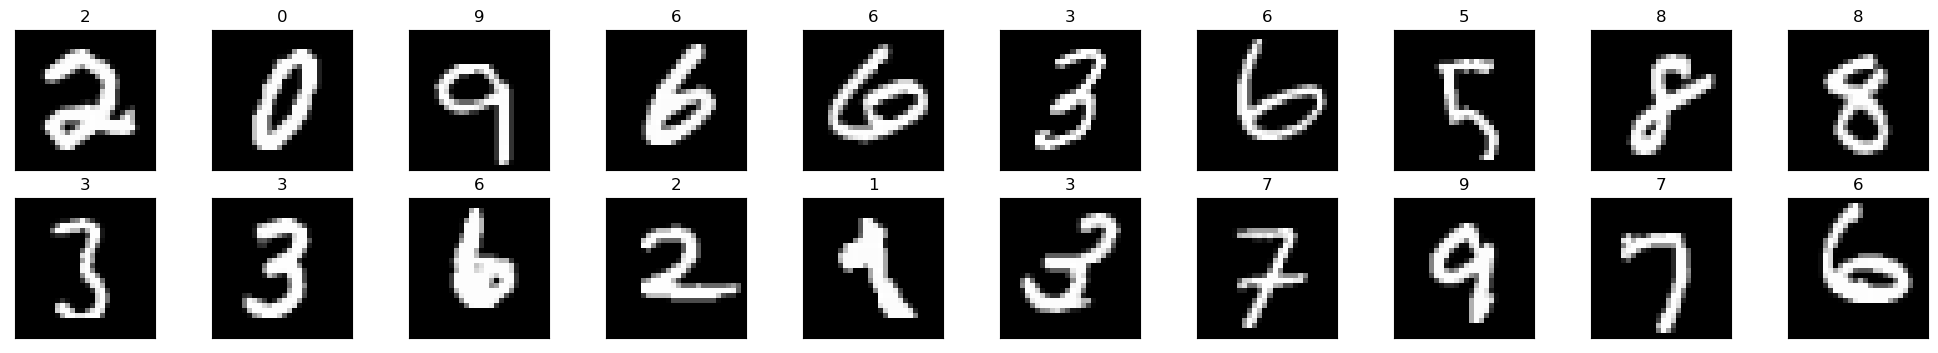

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

# Viewing an Image in More Detail

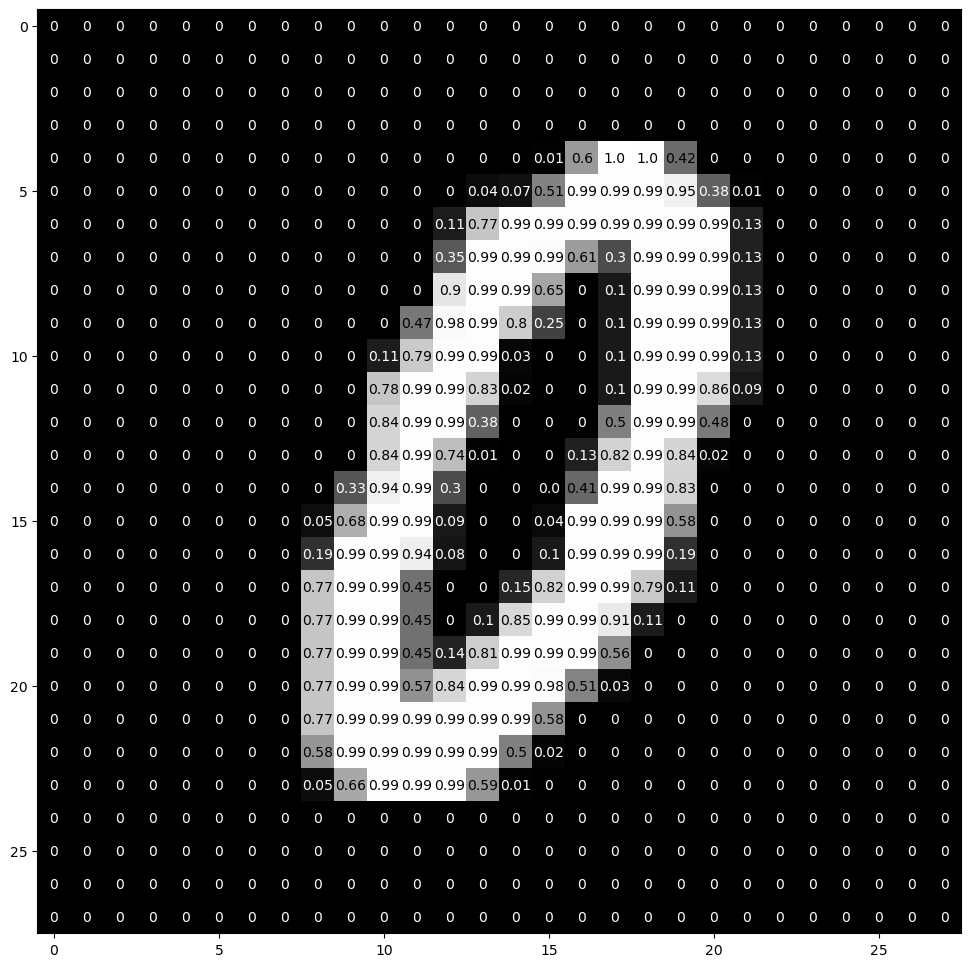

In [12]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Define the Network Achitecture

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        hidden_3 = 400
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, 10)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# Specifying the Loss Function and Optimizer

In [16]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training the Network

In [20]:
n_epochs = 50

valid_loss_min = np.Inf

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()
    
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    print('Epoch: {} \t Training Loss: {:.6g} \tValidation Loss: {:6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
    ))
    
    if valid_loss <= valid_loss_min:
        print('Validation Loss decreased ({:.6f}). Saving Model..'.format(
             valid_loss_min,
             valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	 Training Loss: 0.107916 	Validation Loss: 0.095711
Validation Loss decreased (inf). Saving Model..
Epoch: 2 	 Training Loss: 0.0949491 	Validation Loss: 0.087480
Validation Loss decreased (0.095711). Saving Model..
Epoch: 3 	 Training Loss: 0.0856836 	Validation Loss: 0.084339
Validation Loss decreased (0.087480). Saving Model..
Epoch: 4 	 Training Loss: 0.0751269 	Validation Loss: 0.080147
Validation Loss decreased (0.084339). Saving Model..
Epoch: 5 	 Training Loss: 0.0704285 	Validation Loss: 0.077336
Validation Loss decreased (0.080147). Saving Model..
Epoch: 6 	 Training Loss: 0.0636565 	Validation Loss: 0.073725
Validation Loss decreased (0.077336). Saving Model..
Epoch: 7 	 Training Loss: 0.0595667 	Validation Loss: 0.072499
Validation Loss decreased (0.073725). Saving Model..
Epoch: 8 	 Training Loss: 0.0548106 	Validation Loss: 0.070785
Validation Loss decreased (0.072499). Saving Model..
Epoch: 9 	 Training Loss: 0.048353 	Validation Loss: 0.073535
Epoch: 10 	 Trai

In [21]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

# Testing the Trained Network

In [31]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data, target in test_loader:
    output = model(data)
#     print(output)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
#     print(correct)
    for i in range(batch_size):
        label = target.data[i]
#         print(label)
        class_correct[label] += correct[i].item()
#         print(class_correct)
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test_Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test_Loss: 0.022323

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 98% (1012/1032)
Test Accuracy of     3: 97% (988/1010)
Test Accuracy of     4: 98% (966/982)
Test Accuracy of     5: 97% (873/892)
Test Accuracy of     6: 97% (938/958)
Test Accuracy of     7: 97% (1007/1028)
Test Accuracy of     8: 97% (954/974)
Test Accuracy of     9: 97% (983/1009)

Test Accuracy (Overall): 98% (9821/10000)


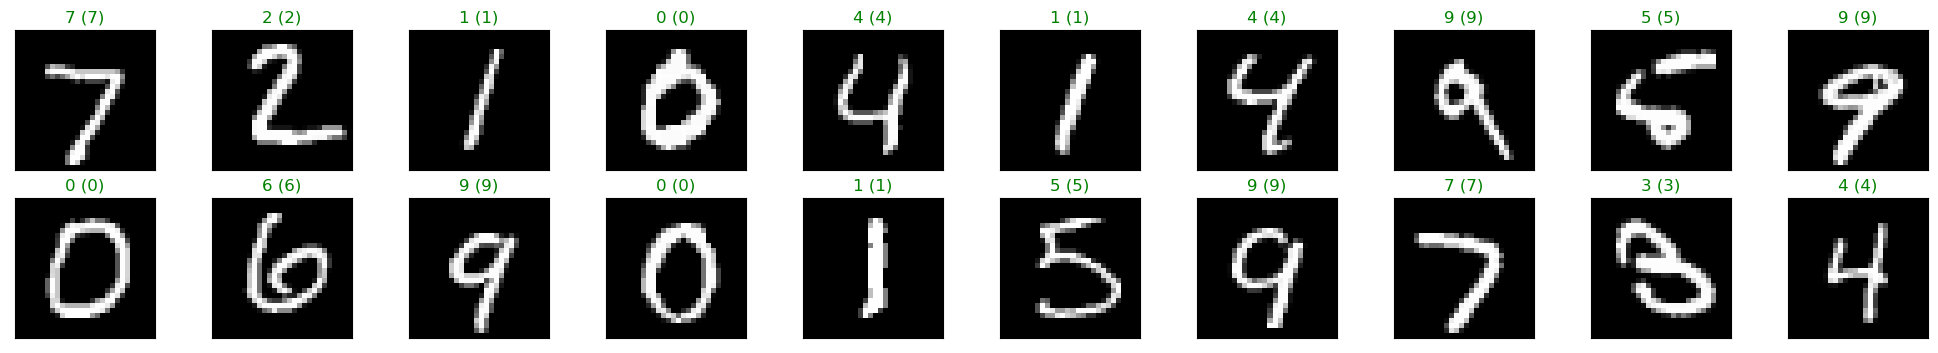

In [34]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))